In [2]:
# Initial imports
import panel as pn
pn.extension('plotly')

import datetime as dt
import hvplot.pandas
import json
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import seaborn as sns
import time
import investpy
import path

from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline

## Part 1: Trading Volume Data

Coinbase provides historical data for their products via their [public API](https://docs.pro.coinbase.com). For the trading volume analysis, the following endpoints are queried: `/currencies` and `/products`.

In [3]:
# Coinbase API endpoints
coinbase_api_url = "https://api.pro.coinbase.com"
cb_products_api_url = f"{coinbase_api_url}/products"
cb_currencies_api_url = f"{coinbase_api_url}/currencies"

In [4]:
# Get currencies (fiat and crypto)
cb_currencies_response = requests.get(cb_currencies_api_url)
cb_currencies = cb_currencies_response.json()
cb_currencies_df = pd.DataFrame(cb_currencies)
cb_currencies_df = pd.concat([cb_currencies_df, pd.io.json.json_normalize(cb_currencies_df["details"])], axis=1).drop(columns=["details"])
cb_currencies_df.head()

,convertible_to,id,max_precision,message,min_size,name,status,crypto_address_link,crypto_transaction_link,display_name,group_types,max_withdrawal_amount,min_withdrawal_amount,network_confirmations,processing_time_seconds,push_payment_methods,sort_order,symbol,type
0,[],ALGO,0.000001,,1,Algorand,online,https://algoexplorer.io/address/{{address}},https://algoexplorer.io/tx/{{txId}},,[],1000000.0,0.1000,1,5,[crypto],93,A,crypto
1,[],DASH,0.00000001,,1,Dash,online,https://chain.so/address/DASH/{{address}},https://chain.so/tx/DASH/{{address}},,[],10000.0,0.0001,2,0,[crypto],47,,crypto
2,[],OXT,0.00000001,,1,Orchid,online,https://etherscan.io/token/0x4575f41308EC1483f...,https://etherscan.io/tx/0x{{txId}},,[],1000000.0,0.0100,35,0,[crypto],48,,crypto
3,[],ATOM,0.000001,,1,Cosmos,online,https://cosmos.bigdipper.live/account/{{address}},https://cosmos.bigdipper.live/transactions/{{t...,,[],100000.0,0.1000,0,5,[crypto],51,,crypto
4,[],KNC,0.00000001,,1,Kyber Network,online,https://etherscan.io/token/0xdd974d5c2e2928dea...,https://etherscan.io/tx/0x{{txId}},,[],2156253.0,0.0100,35,0,[crypto],120,Ξ,crypto


In [5]:
# Get Coinbase products
cb_products_response = requests.get(cb_products_api_url)
cb_products = cb_products_response.json()
cb_products_df = pd.DataFrame(cb_products)
cb_products_df.head()

,base_currency,base_increment,base_max_size,base_min_size,cancel_only,display_name,id,limit_only,margin_enabled,max_market_funds,min_market_funds,post_only,quote_currency,quote_increment,status,status_message,trading_disabled
0,NMR,0.00100000,3900.00000000,0.01000000,False,NMR/GBP,NMR-GBP,False,False,100000,1.0,False,GBP,0.00010000,online,,False
1,LINK,0.01000000,90000.00000000,1.00000000,False,LINK/GBP,LINK-GBP,False,False,100000,10,False,GBP,0.00001000,online,,False
2,BCH,0.00000001,400.00000000,0.01000000,False,BCH/BTC,BCH-BTC,False,False,60,0.001,False,BTC,0.00001000,online,,False
3,LTC,0.00000001,1000.00000000,0.10000000,False,LTC/GBP,LTC-GBP,False,False,250000,10,False,GBP,0.01000000,online,,False
4,LTC,0.00000001,4000.00000000,0.10000000,False,LTC/USD,LTC-USD,False,False,250000,10,False,USD,0.01000000,online,,False


In [6]:
def get_date_list(start_date, end_date, interval=300):
    """
    Get the list of dates in 300-day incremenets.
    """
    delta_days = (end_date - start_date).days
    iterations = math.floor(delta_days / interval) + 1
    date_list = [start_date + dt.timedelta(days=x*interval) for x in range(iterations)]
    return date_list

In [7]:
def get_coinbase_historical_data(id, start_date):
    """
    Get historical data (daily) for a product between the start and end dates.
    """
    start_str = dt.datetime.strftime(start_date, "%Y-%m-%d")
    end_str = dt.datetime.strftime(start_date + dt.timedelta(days=300), "%Y-%m-%d")
    candles_url = f"{cb_products_api_url}/{id}/candles?start={start_str}&end={end_str}&granularity=86400"
    candles_response = requests.get(candles_url)
    candles = candles_response.json()
    candles_df = pd.DataFrame(candles, columns=["time", "low", "high", "open", "close", "volume"])
    return candles_df

In [8]:
# Get list of fiat and cryptocurrencies
cb_crypto_currencies = cb_currencies_df[cb_currencies_df["type"] == "crypto"]["id"].tolist()
cb_fiat_currencies = cb_currencies_df[cb_currencies_df["type"] == "fiat"]["id"].tolist()
# Find Coinbase products bought/sold with fiat currency
cb_fiat_products_df = cb_products_df[cb_products_df["quote_currency"].isin(cb_fiat_currencies)]

print(f"Crypto currencies: {cb_crypto_currencies}\n")
print(f"Fiat currencies: {cb_fiat_currencies}\n")
print(f"{len(cb_fiat_products_df.index)} Coinbase products bought/sold with fiat currency")

Crypto currencies: ['ALGO', 'DASH', 'OXT', 'ATOM', 'KNC', 'XRP', 'REP', 'MKR', 'CGLD', 'COMP', 'NMR', 'OMG', 'BAND', 'UMA', 'XLM', 'EOS', 'ZRX', 'BAT', 'LOOM', 'UNI', 'YFI', 'LRC', 'CVC', 'DNT', 'MANA', 'GNT', 'REN', 'LINK', 'BTC', 'BAL', 'LTC', 'ETH', 'BCH', 'ETC', 'USDC', 'ZEC', 'XTZ', 'DAI', 'WBTC', 'NU', 'FIL', 'AAVE', 'SNX', 'BNT', 'GRT']

Fiat currencies: ['EUR', 'GBP', 'USD']

78 Coinbase products bought/sold with fiat currency


In [9]:
# Get list of dates to fetch data for in 300-day increments
today = dt.datetime.today()
base = dt.datetime.strptime("2021-01-01", "%Y-%m-%d")
cb_date_list = get_date_list(base, today)

# Get data from Coinbase and append to dataframe
trading_volume_data_df = pd.DataFrame()
for idx, row in cb_fiat_products_df.iterrows():
    product_id = row["id"]
    base_currency = row["base_currency"]
    quote_currency = row["quote_currency"]
    for start_date in cb_date_list:
        historical_df = get_coinbase_historical_data(product_id, start_date)
        if not historical_df.empty:
            historical_df["base_currency"] = base_currency
            historical_df["quote_currency"] = quote_currency
            trading_volume_data_df = trading_volume_data_df.append(historical_df)
        time.sleep(2)

trading_volume_data_df.head()

,time,low,high,open,close,volume,base_currency,quote_currency
0,1611964800,18.8872,19.1835,19.1835,18.8872,224.531,NMR,GBP
1,1611878400,18.8672,19.8219,19.1900,19.1972,10831.022,NMR,GBP
2,1611792000,18.4597,20.0000,18.5003,19.2415,2570.438,NMR,GBP
3,1611705600,18.3775,19.7122,19.7121,18.6614,2940.568,NMR,GBP
4,1611619200,18.5705,20.7000,19.6860,19.7121,4828.066,NMR,GBP


In [9]:
# convert epoch time to date
trading_volume_data_df = trading_volume_data_df.drop_duplicates()
trading_volume_data_df["date"] = pd.to_datetime(trading_volume_data_df["time"], unit="s")
trading_volume_data_df = trading_volume_data_df.drop(columns=["time"])

In [10]:
# Export dataframe to CSV for faster loading
cb_data_filepath = Path("../data/coinbase_historical_data.csv")
trading_volume_data_df.to_csv(cb_data_filepath, index=False)

## Part II: Global Indices Data Ingestion & Crypto EDA

In [11]:
#Lookup Countries Parameter for Investpy
investpy.indices.get_index_countries()

['argentina',
 'australia',
 'austria',
 'bahrain',
 'bangladesh',
 'belgium',
 'bosnia',
 'botswana',
 'brazil',
 'bulgaria',
 'canada',
 'chile',
 'china',
 'colombia',
 'costa rica',
 'ivory coast',
 'croatia',
 'cyprus',
 'czech republic',
 'denmark',
 'ecuador',
 'egypt',
 'estonia',
 'finland',
 'france',
 'germany',
 'greece',
 'hong kong',
 'hungary',
 'iceland',
 'india',
 'indonesia',
 'iraq',
 'ireland',
 'israel',
 'italy',
 'jamaica',
 'japan',
 'jordan',
 'kazakhstan',
 'kenya',
 'kuwait',
 'latvia',
 'lebanon',
 'lithuania',
 'luxembourg',
 'malawi',
 'malaysia',
 'malta',
 'mauritius',
 'mexico',
 'mongolia',
 'montenegro',
 'morocco',
 'namibia',
 'netherlands',
 'new zealand',
 'nigeria',
 'norway',
 'oman',
 'pakistan',
 'palestinian territory',
 'peru',
 'philippines',
 'poland',
 'portugal',
 'qatar',
 'romania',
 'russia',
 'rwanda',
 'saudi arabia',
 'serbia',
 'singapore',
 'slovakia',
 'slovenia',
 'south africa',
 'south korea',
 'spain',
 'sri lanka',
 'swede

In [12]:
##Index Lookup DataFrame

global_indices = investpy.indices.get_indices(country= None)

lookup = "KOSDAQ"

global_indices[global_indices['full_name'].str.contains(lookup)]

,country,name,full_name,symbol,currency,class,market
3902,south korea,KQ Grow,KOSDAQ Grow,KQGROW,KRW,other_indices,world_indices
3909,south korea,KQ 150,KOSDAQ 150,KQ150,KRW,other_indices,world_indices
3912,south korea,KQ Venture,KOSDAQ Venture,KQVENTU,KRW,other_indices,world_indices
3913,south korea,KQ Standard,KOSDAQ Standard,KQSTAND,KRW,other_indices,world_indices
3914,south korea,KQ Small,KOSDAQ Small,KQSM,KRW,other_indices,world_indices
3915,south korea,KQ Prime,KOSDAQ Prime,KQPRIME,KRW,other_indices,world_indices
3916,south korea,KQ Mid 300,KOSDAQ Mid 300,KQ300,KRW,other_indices,world_indices
3921,south korea,KQ Metal Product,KOSDAQ Metal Product,KQ28,KRW,other_indices,world_indices
3923,south korea,KQ Nonmetallic Product,KOSDAQ Nonmetallic Product,KQ27,KRW,other_indices,world_indices
3924,south korea,KQ IT S/W & Services,KOSDAQ IT S/W & Services,KQ39,KRW,other_indices,world_indices


In [13]:
#Slice Index Lookup for specific Global Indices
index_list = [5272, 7273, 7282, 6445, 7716, 2357, 4774, 5274, 5275, 5648, 834, 611, 3162, 3090, 3104, 3749, 2270, 2356, 2196, 4747, 4813, 4734, 2088, 2095, 2100, 2599, 2600, 2836, 2848, 410, 576, 560, 580, 3958, 3936] 

top_indices = global_indices[global_indices.index.isin(index_list)]
top_indices

,country,name,full_name,symbol,currency,class,market
410,brazil,Bovespa,Bovespa,BVSP,BRL,major_indices,world_indices
560,canada,S&P/TSX,S&P/TSX Composite,GSPTSE,CAD,major_indices,world_indices
576,canada,S&P/TSX 60,S&P/TSX 60,SPTSE,CAD,additional_indices,world_indices
580,canada,S&P/TSX Venture,S&P/TSX Venture Composite,SPCDNX,CAD,additional_indices,world_indices
611,china,CSI 300 Net TR USD,CSI 300 Net TR USD,CSIID301,USD,other_indices,global_indices
834,china,Shanghai,Shanghai Composite,SSEC,CNY,major_indices,world_indices
2088,france,CAC 40,CAC 40,FCHI,EUR,major_indices,world_indices
2095,france,CAC Next 20,CAC Next 20,CN20,EUR,additional_indices,world_indices
2100,france,CAC Mid 60,CAC Mid 60,CACMD,EUR,additional_indices,world_indices
2196,germany,Midcap,DAX Midcap,MDAXI,EUR,additional_indices,world_indices


In [14]:
#Load GLobal Indices Data
df_410 = investpy.indices.get_index_historical_data(
    index = top_indices.at[410,'name'],
    country = top_indices.at[410,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_410.head()

df_410_ = {}
df_410_[top_indices.at[410,'symbol']] = df_410
df_410_ = pd.concat(df_410_, axis = 1)

df_410_.head()

df_560 = investpy.indices.get_index_historical_data(
    index = top_indices.at[560,'name'],
    country = top_indices.at[560,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_560.head()

df_560_ = {}
df_560_[top_indices.at[560,'symbol']] = df_560
df_560_ = pd.concat(df_560_, axis = 1)

df_560_.head()

df_576 = investpy.indices.get_index_historical_data(
    index = top_indices.at[576,'name'],
    country = top_indices.at[576,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_576.head()

df_576_ = {}
df_576_[top_indices.at[576,'symbol']] = df_576
df_576_ = pd.concat(df_576_, axis = 1)

df_576_.head()

df_580 = investpy.indices.get_index_historical_data(
    index = top_indices.at[580,'name'],
    country = top_indices.at[580,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_580.head()

df_580_ = {}
df_580_[top_indices.at[580,'symbol']] = df_580
df_580_ = pd.concat(df_580_, axis = 1)

df_580_.head()

df_611 = investpy.indices.get_index_historical_data(
    index = top_indices.at[611,'name'],
    country = top_indices.at[611,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_611.head()

df_611_ = {}
df_611_[top_indices.at[611,'symbol']] = df_611
df_611_ = pd.concat(df_611_, axis = 1)

df_611_.head()

df_834 = investpy.indices.get_index_historical_data(
    index = top_indices.at[834,'name'],
    country = top_indices.at[834,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_834.head()

df_834_ = {}
df_834_[top_indices.at[834,'symbol']] = df_834
df_834_ = pd.concat(df_834_, axis = 1)

df_834_.head()

df_2088 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2088,'name'],
    country = top_indices.at[2088,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2088.head()

df_2088_ = {}
df_2088_[top_indices.at[2088,'symbol']] = df_2088
df_2088_ = pd.concat(df_2088_, axis = 1)

df_2088_.head()

df_2095 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2095,'name'],
    country = top_indices.at[2095,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2095.head()

df_2095_ = {}
df_2095_[top_indices.at[2095,'symbol']] = df_2095
df_2095_ = pd.concat(df_2095_, axis = 1)

df_2095_.head()

df_2100 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2100,'name'],
    country = top_indices.at[2100,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2100.head()

df_2100_ = {}
df_2100_[top_indices.at[2100,'symbol']] = df_2100
df_2100_ = pd.concat(df_2100_, axis = 1)

df_2100_.head()

df_2196 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2196,'name'],
    country = top_indices.at[2196,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2196.head()

df_2196_ = {}
df_2196_[top_indices.at[2196,'symbol']] = df_2196
df_2196_ = pd.concat(df_2196_, axis = 1)

df_2196_.head()

df_2270 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2270,'name'],
    country = top_indices.at[2270,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2270.head()

df_2270_ = {}
df_2270_[top_indices.at[2270,'symbol']] = df_2270
df_2270_ = pd.concat(df_2270_, axis = 1)

df_2270_.head()

df_2356	= investpy.indices.get_index_historical_data(
    index = top_indices.at[2356,'name'],
    country = top_indices.at[2356,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2356.head()

df_2356_ = {}
df_2356_[top_indices.at[2356,'symbol']] = df_2356
df_2356_ = pd.concat(df_2356_, axis = 1)

df_2356_.head()

df_2357 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2357,'name'],
    country = top_indices.at[2357,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2357.head()

df_2357_ = {}
df_2357_[top_indices.at[2357,'symbol']] = df_2357
df_2357_ = pd.concat(df_2357_, axis = 1)

df_2357_.head()

df_2599 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2599,'name'],
    country = top_indices.at[2599,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2599.head()

df_2599_ = {}
df_2599_[top_indices.at[2599,'symbol']] = df_2599
df_2599_ = pd.concat(df_2599_, axis = 1)

df_2599_.head()

df_2600 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2600,'name'],
    country = top_indices.at[2600,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2600.head()

df_2600_ = {}
df_2600_[top_indices.at[2600,'symbol']] = df_2600
df_2600_ = pd.concat(df_2600_, axis = 1)

df_2600_.head()

df_2836 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2836,'name'],
    country = top_indices.at[2836,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2836.head()

df_2836_ = {}
df_2836_[top_indices.at[2836,'symbol']] = df_2836
df_2836_ = pd.concat(df_2836_, axis = 1)

df_2836_.head()

df_2848 = investpy.indices.get_index_historical_data(
    index = top_indices.at[2848,'name'],
    country = top_indices.at[2848,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_2848.head()

df_2848_ = {}
df_2848_[top_indices.at[2848,'symbol']] = df_2848
df_2848_ = pd.concat(df_2848_, axis = 1)

df_2848_.head()

df_3090 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3090,'name'],
    country = top_indices.at[3090,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3090.head()

df_3090_ = {}
df_3090_[top_indices.at[3090,'symbol']] = df_3090
df_3090_ = pd.concat(df_3090_, axis = 1)

df_3090_.head()

df_3104 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3104,'name'],
    country = top_indices.at[3104,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3104.head()

df_3104_ = {}
df_3104_[top_indices.at[3104,'symbol']] = df_3104
df_3104_ = pd.concat(df_3104_, axis = 1)

df_3104_.head()

df_3162 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3162,'name'],
    country = top_indices.at[3162,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3162.head()

df_3162_ = {}
df_3162_[top_indices.at[3162,'symbol']] = df_3162
df_3162_ = pd.concat(df_3162_, axis = 1)

df_3162_.head()

df_3749 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3749,'name'],
    country = top_indices.at[3749,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3749.head()

df_3749_ = {}
df_3749_[top_indices.at[3749,'symbol']] = df_3749
df_3749_ = pd.concat(df_3749_, axis = 1)

df_3749_.head()

df_3936 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3936,'name'],
    country = top_indices.at[3936,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3936.head()

df_3936_ = {}
df_3936_[top_indices.at[3936,'symbol']] = df_3936
df_3936_ = pd.concat(df_3936_, axis = 1)

df_3936_.head()

df_3958 = investpy.indices.get_index_historical_data(
    index = top_indices.at[3958,'name'],
    country = top_indices.at[3958,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_3958.head()

df_3958_ = {}
df_3958_[top_indices.at[3958,'symbol']] = df_3958
df_3958_ = pd.concat(df_3958_, axis = 1)

df_3958_.head()

df_4734 = investpy.indices.get_index_historical_data(
    index = top_indices.at[4734,'name'],
    country = top_indices.at[4734,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_4734.head()

df_4734_ = {}
df_4734_[top_indices.at[4734,'symbol']] = df_4734
df_4734_ = pd.concat(df_4734_, axis = 1)

df_4734_.head()

df_4747 = investpy.indices.get_index_historical_data(
    index = top_indices.at[4747,'name'],
    country = top_indices.at[4747,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_4747.head()

df_4747_ = {}
df_4747_[top_indices.at[4747,'symbol']] = df_4747
df_4747_ = pd.concat(df_4747_, axis = 1)

df_4747_.head()

df_4774 = investpy.indices.get_index_historical_data(
    index = top_indices.at[4774,'name'],
    country = top_indices.at[4774,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_4774.head()

df_4774_ = {}
df_4774_[top_indices.at[4774,'symbol']] = df_4774
df_4774_ = pd.concat(df_4774_, axis = 1)

df_4774_.head()

df_4813 = investpy.indices.get_index_historical_data(
    index = top_indices.at[4813,'name'],
    country = top_indices.at[4813,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_4813.head()

df_4813_ = {}
df_4813_[top_indices.at[4813,'symbol']] = df_4813
df_4813_ = pd.concat(df_4813_, axis = 1)

df_4813_.head()

df_5272 = investpy.indices.get_index_historical_data(
    index = top_indices.at[5272,'name'],
    country = top_indices.at[5272,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_5272.head()

df_5272_ = {}
df_5272_[top_indices.at[5272,'symbol']] = df_5272
df_5272_ = pd.concat(df_5272_, axis = 1)

df_5272_.head()

df_5274 = investpy.indices.get_index_historical_data(
    index = top_indices.at[5274,'name'],
    country = top_indices.at[5274,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_5274.head()

df_5274_ = {}
df_5274_[top_indices.at[5274,'symbol']] = df_5274
df_5274_ = pd.concat(df_5274_, axis = 1)

df_5274_.head()

df_5275 = investpy.indices.get_index_historical_data(
    index = top_indices.at[5275,'name'],
    country = top_indices.at[5275,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_5275.head()

df_5275_ = {}
df_5275_[top_indices.at[5275,'symbol']] = df_5275
df_5275_ = pd.concat(df_5275_, axis = 1)

df_5275_.head()

df_5648 = investpy.indices.get_index_historical_data(
    index = top_indices.at[5648,'name'],
    country = top_indices.at[5648,'country'],
    from_date = '01/01/2000',
    to_date = '01/01/2021'    
)

df_5648.head()

df_5648_ = {}
df_5648_[top_indices.at[5648,'symbol']] = df_5648
df_5648_ = pd.concat(df_5648_, axis = 1)

df_5648_.head()

W5000                                              
                Open      High       Low     Close Volume Currency
Date                                                              
2012-01-30  13891.16  13891.16  13719.73  13844.69      0      USD
2012-01-31  13844.69  13934.15  13778.69  13839.11      0      USD
2012-02-01  13839.11  14045.95  13839.11  13990.02      0      USD
2012-02-02  13990.02  14055.22  13971.90  14015.25      0      USD
2012-02-03  14015.25  14234.83  14015.25  14231.81      0      USD

In [15]:
#Combine all Global Index DataFrames
df_indices_all = pd.concat([df_2088_, df_2095_, df_2100_, df_2196_, df_2270_, df_2356_, df_2357_, df_2599_, df_2600_, df_2836_, df_2848_, df_3090_, df_3104_, df_3162_, df_3749_, df_3936_, df_3958_, df_410_, df_4734_, df_4747_, df_4774_, df_4813_, df_5272_, df_5274_, df_5275_, df_560_, df_5648_, df_611_, df_834_], axis = 1)

df_indices_all.head()

FCHI                                                     CN20  \
               Open     High      Low    Close      Volume Currency     Open   
Date                                                                           
2000-01-03  6024.38  6102.12  5901.77  5917.37  19890184.0      EUR  5223.65   
2000-01-04  5922.23  5925.07  5657.20  5672.02  30354062.0      EUR  5003.78   
2000-01-05  5521.83  5589.50  5461.59  5479.70  29936202.0      EUR  4860.54   
2000-01-06  5485.93  5530.26  5388.85  5450.11  29744336.0      EUR  4797.12   
2000-01-07  5423.88  5561.69  5423.88  5539.61  38625352.0      EUR  4956.08   

                                       ... CSIID301                        \
               High      Low    Close  ...      Low Close Volume Currency   
Date                                   ...                                  
2000-01-03  5223.65  5223.65  5223.65  ...      NaN   NaN    NaN      NaN   
2000-01-04  5003.78  5003.78  5003.78  ...      NaN   NaN    NaN      NaN   
2000-01-05  4860.54  4860.54  4860.54  ...      NaN   NaN    NaN      NaN   
2000-01-06  4797.12  4797.12  4797.12  ...      NaN   NaN    NaN      NaN   
2000-01-07  4956.08  4956.08  4956.08  ...      NaN   NaN    NaN      NaN   

               SSEC                                                    
               Open     High      Low    Close        Volume Currency  
Date                                                                   
2000-01-03      NaN      NaN      NaN      NaN           NaN      NaN  
2000-01-04  1368.69  1407.52  1361.21  1406.37  4.370933e+08      CNY  
2000-01-05  1407.83  1433.78  1398.32  1409.68  6.880885e+08      CNY  
2000-01-06  1406.04  1463.95  1400.25  1463.94  8.090454e+08      CNY  
2000-01-07  1477.15  1522.83  1477.15  1516.60  1.599787e+09      CNY  

[5 rows x 174 columns]

In [16]:
#Reduce Variables
df_indices_close_vol = df_indices_all
df_indices_close_vol.drop(columns = ['Open', 'High', 'Low', 'Currency'], inplace = True, axis = 1, level = 1)
df_indices_close_vol.head()

FCHI                 CN20           CACMD           MDAXI  \
              Close      Volume    Close Volume    Close Volume    Close   
Date                                                                       
2000-01-03  5917.37  19890184.0  5223.65    0.0  4300.80    0.0  4127.35   
2000-01-04  5672.02  30354062.0  5003.78    0.0  4180.70    0.0  4048.81   
2000-01-05  5479.70  29936202.0  4860.54    0.0  4043.97    0.0  3994.87   
2000-01-06  5450.11  29744336.0  4797.12    0.0  4070.06    0.0  4016.15   
2000-01-07  5539.61  38625352.0  4956.08    0.0  4144.11    0.0  4095.51   

                      TECDAX         ...   SPX          GSPTSE              \
             Volume    Close Volume  ... Close Volume    Close      Volume   
Date                                 ...                                     
2000-01-03   9776.0  5151.36    0.0  ...   NaN    NaN      NaN         NaN   
2000-01-04   9974.0  4977.74    0.0  ...   NaN    NaN  8202.60  59509832.0   
2000-01-05  10000.0  4810.34    0.0  ...   NaN    NaN  8119.42  94545728.0   
2000-01-06   9849.0  4789.80    0.0  ...   NaN    NaN  8114.24  79690120.0   
2000-01-07   9804.0  4984.45    0.0  ...   NaN    NaN  8429.42  87693168.0   

           W5000        CSIID301            SSEC                
           Close Volume    Close Volume    Close        Volume  
Date                                                            
2000-01-03   NaN    NaN      NaN    NaN      NaN           NaN  
2000-01-04   NaN    NaN      NaN    NaN  1406.37  4.370933e+08  
2000-01-05   NaN    NaN      NaN    NaN  1409.68  6.880885e+08  
2000-01-06   NaN    NaN      NaN    NaN  1463.94  8.090454e+08  
2000-01-07   NaN    NaN      NaN    NaN  1516.60  1.599787e+09  

[5 rows x 58 columns]

In [17]:
#Global Index Close DataFrame
df_indices_close = df_indices_all
df_indices_close.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Currency'], inplace = True, axis = 1, level = 1)
df_indices_close.columns = df_indices_close.columns.droplevel(1)
df_indices_close

,FCHI,CN20,CACMD,MDAXI,TECDAX,GDAXI,STOXX50E,BSESN,NSEI,FTMIB,...,FTSE,FTEUEB,FTAS,DJI,IXIC,SPX,GSPTSE,W5000,CSIID301,SSEC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5917.37,5223.65,4300.80,4127.35,5151.36,NaN,NaN,NaN,1592.20,NaN,...,NaN,NaN,NaN,NaN,4131.15,NaN,NaN,NaN,NaN,NaN
2000-01-04,5672.02,5003.78,4180.70,4048.81,4977.74,NaN,NaN,NaN,1638.70,NaN,...,NaN,NaN,NaN,NaN,3901.69,NaN,8202.60,NaN,NaN,1406.37
2000-01-05,5479.70,4860.54,4043.97,3994.87,4810.34,NaN,NaN,NaN,1595.80,NaN,...,NaN,NaN,NaN,NaN,3877.54,NaN,8119.42,NaN,NaN,1409.68
2000-01-06,5450.11,4797.12,4070.06,4016.15,4789.80,NaN,NaN,NaN,1617.60,NaN,...,NaN,NaN,NaN,NaN,3727.13,NaN,8114.24,NaN,NaN,1463.94
2000-01-07,5539.61,4956.08,4144.11,4095.51,4984.45,NaN,NaN,NaN,1613.30,NaN,...,NaN,NaN,NaN,NaN,3882.62,NaN,8429.42,NaN,NaN,1516.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,5588.38,12016.43,13494.31,30655.69,3212.32,13790.29,3575.41,47353.75,13873.20,22288.52,...,NaN,1225.83,NaN,30403.97,12899.42,3735.36,NaN,39358.07,NaN,3397.29
2020-12-29,5611.79,12078.96,13574.18,30912.39,3217.97,13761.38,3581.37,47613.08,13932.60,22259.35,...,6602.65,1227.99,3750.91,30335.67,12850.22,3727.04,17543.43,39200.60,NaN,3379.04
2020-12-30,5599.41,12042.96,13523.82,30796.26,3212.77,13718.78,3571.59,47746.22,13981.95,22232.90,...,6555.82,1224.37,3723.98,30409.56,12870.00,3732.04,17545.81,39301.24,NaN,3414.45


In [18]:
#Calculate Global Index Returns
df_indices_close_returns = df_indices_close.pct_change()
df_indices_close_returns.describe()

,FCHI,CN20,CACMD,MDAXI,TECDAX,GDAXI,STOXX50E,BSESN,NSEI,FTMIB,...,FTSE,FTEUEB,FTAS,DJI,IXIC,SPX,GSPTSE,W5000,CSIID301,SSEC
count,5593.000000,5593.000000,5593.000000,5593.000000,5593.000000,5328.000000,2524.000000,2647.000000,5593.000000,4688.000000,...,5328.000000,2524.000000,2517.000000,3736.000000,5593.000000,4003.000000,5592.000000,2402.000000,1931.000000,5592.000000
mean,0.000089,0.000229,0.000263,0.000437,0.000079,0.000248,0.000249,0.000433,0.000488,0.000397,...,0.000081,0.000263,0.000169,0.000315,0.000324,0.000347,0.000196,0.000489,0.000297,0.000271
std,0.014155,0.012721,0.010823,0.012454,0.018084,0.014528,0.012681,0.010528,0.014056,0.026119,...,0.011654,0.012145,0.009670,0.012204,0.015559,0.012391,0.010999,0.010205,0.012554,0.014740
min,-0.122768,-0.136989,-0.113868,-0.109105,-0.120101,-0.122386,-0.124014,-0.131526,-0.129805,-0.169238,...,-0.108745,-0.125752,-0.104914,-0.129265,-0.123213,-0.119841,-0.123450,-0.122446,-0.107633,-0.088407
25%,-0.006253,-0.005446,-0.004496,-0.004912,-0.007594,-0.005863,-0.005134,-0.004203,-0.005481,-0.006170,...,-0.004949,-0.004859,-0.003974,-0.003589,-0.005577,-0.003520,-0.003990,-0.002976,0.000000,-0.005654
50%,0.000000,0.000378,0.000497,0.000549,0.000112,0.000165,0.000000,0.000000,0.000105,0.000000,...,0.000000,0.000000,0.000000,0.000208,0.000337,0.000255,0.000217,0.000154,0.000000,0.000000
75%,0.006808,0.006251,0.005533,0.006487,0.008513,0.006887,0.005927,0.005517,0.007154,0.006909,...,0.005490,0.005786,0.004583,0.005049,0.007072,0.005238,0.005144,0.004904,0.000000,0.006434
max,0.111762,0.097104,0.076021,0.119590,0.143533,0.114020,0.092362,0.089749,0.177441,1.474352,...,0.098387,0.087232,0.088612,0.113650,0.141732,0.115800,0.119570,0.092471,0.071976,0.098568


In [19]:
#Calculate Cummulative Global Index Returns
df_indices_close_returns_sum = (1 + df_indices_close_returns).cumprod()
df_indices_close_returns_sum.describe()

,FCHI,CN20,CACMD,MDAXI,TECDAX,GDAXI,STOXX50E,BSESN,NSEI,FTMIB,...,FTSE,FTEUEB,FTAS,DJI,IXIC,SPX,GSPTSE,W5000,CSIID301,SSEC
count,5593.000000,5593.000000,5593.000000,5593.000000,5593.000000,5328.000000,2524.000000,2647.000000,5593.000000,4688.000000,...,5328.000000,2524.000000,2517.000000,3736.000000,5593.000000,4003.000000,5592.000000,2402.000000,1931.000000,5592.000000
mean,0.755902,1.346489,1.799363,3.048416,0.289827,1.200714,1.342271,1.573328,3.420232,2.302282,...,0.974514,1.387540,1.334296,1.354609,0.919492,1.458210,1.483438,1.710013,1.410519,1.769766
std,0.155093,0.546986,0.808512,1.937502,0.253696,0.479813,0.179281,0.438205,2.137591,0.745004,...,0.169324,0.203518,0.146861,0.472141,0.571859,0.544645,0.362502,0.421857,0.234425,0.621648
min,0.406099,0.480271,0.579497,0.641305,0.060091,0.342342,0.858261,0.860636,0.536490,0.971787,...,0.544214,0.868521,0.947671,0.524574,0.269685,0.531253,0.694332,0.965848,0.858345,0.719228
25%,0.630902,0.878064,1.074082,1.285585,0.134477,0.819127,1.244489,1.132732,1.298612,1.841004,...,0.861715,1.281517,1.245408,0.989418,0.510834,1.024669,1.164565,1.429868,1.321565,1.254170
50%,0.750301,1.178548,1.619801,2.362845,0.178671,1.082344,1.373219,1.554157,3.267052,2.100588,...,0.981549,1.409137,1.336954,1.287676,0.662627,1.304572,1.524801,1.612185,1.522758,1.715765
75%,0.878111,1.826970,2.501811,4.877076,0.356890,1.630556,1.483662,1.945280,5.137514,2.696439,...,1.104245,1.564933,1.467607,1.710613,1.190964,1.857604,1.781650,2.049665,1.522758,2.171603
max,1.169832,2.578211,3.530122,7.489646,1.869706,2.143027,1.662815,2.714829,8.804484,4.346003,...,1.304235,1.735917,1.602191,2.452307,3.122477,2.949500,2.187606,2.849949,2.269121,4.331762


In [20]:
#Calculate Global Index Correlations
df_indices_close_returns_corr = df_indices_close_returns.corr()
df_indices_close_returns_corr

,FCHI,CN20,CACMD,MDAXI,TECDAX,GDAXI,STOXX50E,BSESN,NSEI,FTMIB,...,FTSE,FTEUEB,FTAS,DJI,IXIC,SPX,GSPTSE,W5000,CSIID301,SSEC
FCHI,1.000000,0.860348,0.842437,0.833544,0.726648,0.905663,0.982510,0.432725,0.339230,0.519280,...,0.883989,0.984113,0.874203,0.611074,0.494362,0.608133,0.549215,0.595636,0.067368,0.117624
CN20,0.860348,1.000000,0.878175,0.833376,0.711435,0.810819,0.877817,0.466842,0.381503,0.467038,...,0.810337,0.893618,0.835728,0.570852,0.436116,0.563700,0.520178,0.567657,0.061200,0.131965
CACMD,0.842437,0.878175,1.000000,0.874715,0.720414,0.782751,0.885725,0.455614,0.421337,0.473433,...,0.787413,0.902844,0.838292,0.570369,0.440808,0.564477,0.533341,0.572816,0.069794,0.153996
MDAXI,0.833544,0.833376,0.874715,1.000000,0.725223,0.822738,0.889063,0.443512,0.401914,0.464363,...,0.795680,0.905757,0.835664,0.574254,0.451845,0.578892,0.531867,0.570836,0.065073,0.144928
TECDAX,0.726648,0.711435,0.720414,0.725223,1.000000,0.771880,0.776429,0.377182,0.324307,0.416021,...,0.694639,0.795161,0.728025,0.520807,0.529470,0.530506,0.492999,0.506421,0.049499,0.096912
GDAXI,0.905663,0.810819,0.782751,0.822738,0.771880,1.000000,0.962863,0.418402,0.335523,0.494882,...,0.814170,0.967584,0.844541,0.623657,0.568043,0.620152,0.553011,0.587801,0.062348,0.117164
STOXX50E,0.982510,0.877817,0.885725,0.889063,0.776429,0.962863,1.000000,0.434277,0.429970,0.904959,...,0.856082,0.997233,0.863383,0.618211,0.560276,0.615999,0.607860,0.596113,0.063314,0.163304
BSESN,0.432725,0.466842,0.455614,0.443512,0.377182,0.418402,0.434277,1.000000,0.993218,0.364678,...,0.435037,0.444561,0.467774,0.298119,0.258547,0.296855,0.365531,0.320359,0.079652,0.216284
NSEI,0.339230,0.381503,0.421337,0.401914,0.324307,0.335523,0.429970,0.993218,1.000000,0.225211,...,0.366741,0.440248,0.461672,0.298439,0.184833,0.284894,0.266004,0.314026,0.083028,0.189744
FTMIB,0.519280,0.467038,0.473433,0.464363,0.416021,0.494882,0.904959,0.364678,0.225211,1.000000,...,0.457389,0.907107,0.764655,0.552895,0.305161,0.554175,0.308157,0.541997,0.050631,0.082651


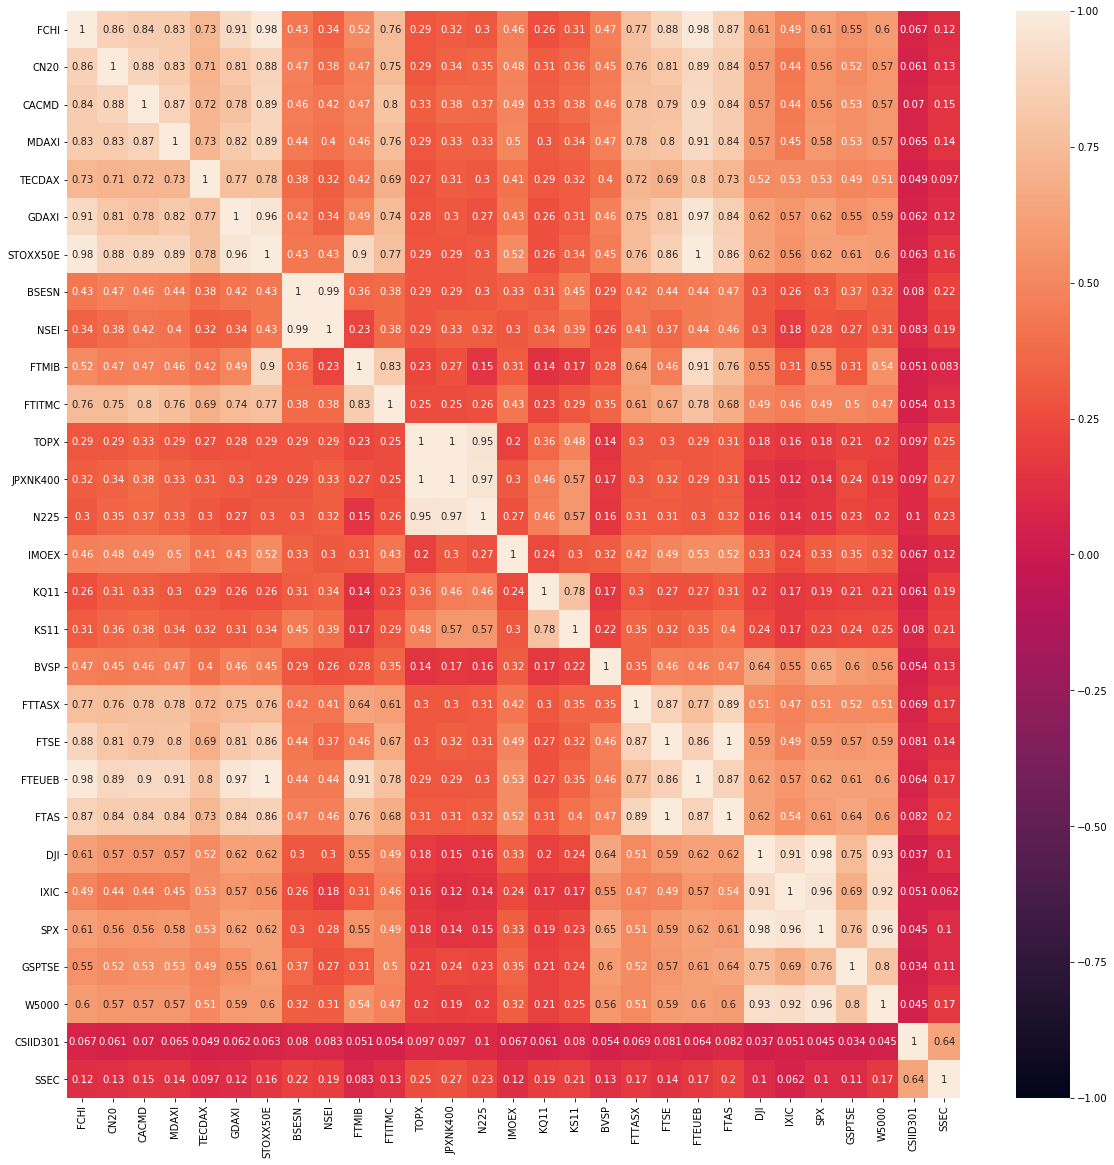

In [21]:
#Global Index Correlation Heatmap
plt.subplots(figsize=(20,20))
heatmap = sns.heatmap(df_indices_close_returns_corr, vmin = -1, vmax = 1, annot = True).get_figure()
heatmap_path = Path('../images/indices_corr_heatmap.png')
heatmap.savefig(heatmap_path)

In [22]:
#Melt Returns DataFrame
df_indices_close_melt = df_indices_close_returns.reset_index()
df_indices_close_melt = df_indices_close_melt.melt(id_vars = ['Date'], var_name = 'Index', value_name = 'Close')
df_indices_close_melt.sort_index(axis=0, level=None, ascending=True, inplace=False)
df_indices_close_melt.describe()

,Close
count,126409.000000
mean,0.000301
std,0.014482
min,-0.186631
25%,-0.005166
50%,0.000000
75%,0.006428
max,1.474352


In [23]:
#Get Returns Index for Join
top_indices.head()
top_indices_2 = top_indices.set_index('symbol')
top_indices_2.head()

df_indices_close_melt_2 = df_indices_close_melt.set_index('Index')
df_indices_close_melt_2.head()

,Date,Close
Index,,
FCHI,2000-01-03,NaN
FCHI,2000-01-04,-0.041463
FCHI,2000-01-05,-0.033907
FCHI,2000-01-06,-0.005400
FCHI,2000-01-07,0.016422


In [24]:
#Melt Cummulative Returns Table for Join
df_indices_close_returns_sum_melt = df_indices_close_returns_sum.reset_index()
df_indices_close_returns_sum_melt = df_indices_close_returns_sum_melt.melt(id_vars = ['Date'], var_name = 'Index', value_name = 'returns_sum')
df_indices_close_returns_sum_melt = df_indices_close_returns_sum_melt.sort_index(axis=0, level=None, ascending=True, inplace=False)
df_indices_close_returns_sum_melt = df_indices_close_returns_sum_melt.rename(columns = {'Index' : 'index'})
df_indices_close_returns_sum_melt = df_indices_close_returns_sum_melt.set_index(['Date', 'index']).dropna(subset = ['returns_sum'])
df_indices_close_returns_sum_melt = df_indices_close_returns_sum_melt.sort_values(by = ['Date', 'index'], ascending = (True, True))
df_indices_close_returns_sum_melt.describe()

,returns_sum
count,126409.000000
mean,1.859897
std,1.959670
min,0.060091
25%,0.922638
50%,1.354622
75%,1.959158
max,19.011676


In [25]:
#Join Returns to Index Dim
df_index_close = top_indices_2.join(df_indices_close_melt_2, how = 'right')
df_index_close = df_index_close.reset_index().set_index(['Date', 'index']).dropna(subset = ['Close'])
df_index_close = df_index_close.sort_values(by = ['Date', 'index'], ascending = (True, True))
df_index_close.head()

country         name         full_name currency  \
Date       index                                                          
2000-01-04 CACMD         france   CAC Mid 60        CAC Mid 60      EUR   
           CN20          france  CAC Next 20       CAC Next 20      EUR   
           FCHI          france       CAC 40            CAC 40      EUR   
           IXIC   united states       Nasdaq  NASDAQ Composite      USD   
           MDAXI        germany       Midcap        DAX Midcap      EUR   

                               class         market     Close  
Date       index                                               
2000-01-04 CACMD  additional_indices  world_indices -0.027925  
           CN20   additional_indices  world_indices -0.042091  
           FCHI        major_indices  world_indices -0.041463  
           IXIC        major_indices  world_indices -0.055544  
           MDAXI  additional_indices  world_indices -0.019029

In [26]:
#Join Cummulative Returns to Index Dim
df_index_all = df_index_close.join(df_indices_close_returns_sum_melt, on = ['Date', 'index'])
df_index_all.describe()

,Close,returns_sum
count,126409.000000,126409.000000
mean,0.000301,1.859897
std,0.014482,1.959670
min,-0.186631,0.060091
25%,-0.005166,0.922638
50%,0.000000,1.354622
75%,0.006428,1.959158
max,1.474352,19.011676


In [27]:
#Groom Index Table
df_index_all = df_index_all.reset_index().rename(columns = {'Date': 'date', 'Close': 'returns', 'index' : 'symbol'}).set_index(['date'])
df_index_all['asset_type'] = 'index'
df_index_all.head()

,symbol,country,name,full_name,currency,class,market,returns,returns_sum,asset_type
date,,,,,,,,,,
2000-01-04,CACMD,france,CAC Mid 60,CAC Mid 60,EUR,additional_indices,world_indices,-0.027925,0.972075,index
2000-01-04,CN20,france,CAC Next 20,CAC Next 20,EUR,additional_indices,world_indices,-0.042091,0.957909,index
2000-01-04,FCHI,france,CAC 40,CAC 40,EUR,major_indices,world_indices,-0.041463,0.958537,index
2000-01-04,IXIC,united states,Nasdaq,NASDAQ Composite,USD,major_indices,world_indices,-0.055544,0.944456,index
2000-01-04,MDAXI,germany,Midcap,DAX Midcap,EUR,additional_indices,world_indices,-0.019029,0.980971,index


In [28]:
#Load Crypto Historical Data for Reference with Global Indices
#Crypto

coinbase_historical_data_path = Path("../data/CoinMarketCap_18JAN2020-close.csv")
crypto_data = pd.read_csv(coinbase_historical_data_path)
crypto_data["Date"] = pd.to_datetime(crypto_data["Date"])
crypto_data = crypto_data.rename(columns = {'Date': 'date'})
crypto_data = crypto_data.set_index(['date']).sort_index()
crypto_data.head()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
date,,,,,,,,,,
2013-04-28,144.54,NaN,NaN,4.38,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,139.00,NaN,NaN,4.30,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,116.99,NaN,NaN,3.80,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,105.21,NaN,NaN,3.37,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,97.75,NaN,NaN,3.04,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#Calculate Crypto Returns
crypto_returns = crypto_data.pct_change()
crypto_returns.describe()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
count,2804.000000,1973.000000,783.000000,2804.000000,2416.000000,2512.000000,384.000000,1523.000000,1256.000000,254.000000
mean,0.002790,0.005405,0.004618,0.003269,0.004024,0.005252,0.014072,0.001324,0.002536,0.007841
std,0.042210,0.062685,0.096960,0.068340,0.069320,0.089842,0.096691,0.082160,0.075627,0.068797
min,-0.371695,-0.423462,-0.463989,-0.401857,-0.389946,-0.373441,-0.304545,-0.362249,-0.429589,-0.459503
25%,-0.012136,-0.022436,-0.023320,-0.020548,-0.027831,-0.025488,-0.039234,-0.031164,-0.027838,-0.001470
50%,0.001896,0.000178,-0.001757,0.000000,0.000000,-0.001419,0.000000,-0.003300,-0.002545,0.000264
75%,0.018267,0.028371,0.020974,0.020540,0.032831,0.025966,0.052282,0.029019,0.026037,0.002948
max,0.429680,0.510446,1.424941,1.290954,0.794340,2.562654,0.590750,1.826241,0.539691,0.849513


In [30]:
#Calculate Crypto Cummulative Returns
crypto_returns_sum = (1 + crypto_returns).cumprod()
crypto_returns_sum.describe()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
count,2804.000000,1973.000000,783.000000,2804.000000,2416.000000,2512.000000,384.000000,1523.000000,1256.000000,254.000000
mean,28.589035,297.094868,1.696785,9.006871,28.857308,359.390514,9.493333,0.235430,1.181081,1.764711
std,32.730368,307.765302,0.727044,11.394378,36.435141,595.229324,10.134599,0.240595,1.150858,1.194686
min,0.473433,0.577194,0.491041,0.264840,0.106429,1.292474,0.582857,0.042622,0.175562,0.968106
25%,2.891639,16.792778,1.039685,0.849315,0.594048,13.337567,1.462857,0.089698,0.534417,1.001472
50%,7.473641,240.050445,1.786125,4.737443,22.030952,216.465545,3.905714,0.122264,0.714364,1.003435
75%,52.300073,406.836586,2.160234,13.082192,42.623810,389.925373,18.151429,0.335261,1.273514,2.315751
max,203.225059,1853.736891,4.855732,81.812785,223.428571,4924.896793,41.120000,2.826241,8.901906,4.371933


In [31]:
#Melt Crypto Returns
crypto_returns_melt = crypto_returns.reset_index().melt(id_vars = ['date'], var_name = 'symbol', value_name = 'returns').set_index(['date', 'symbol']).dropna(subset = ['returns']).drop_duplicates()
crypto_returns_melt['asset_type'] = 'crypto'
crypto_returns_melt = crypto_returns_melt.reset_index().set_index(['date', 'symbol', 'asset_type'])
crypto_returns_melt.head()

crypto_returns_sum_melt = crypto_returns_sum.reset_index().melt(id_vars = ['date'], var_name = 'symbol', value_name = 'returns_sum').set_index(['date', 'symbol']).dropna(subset = ['returns_sum']).drop_duplicates()
crypto_returns_sum_melt['asset_type'] = 'crypto'
crypto_returns_sum_melt = crypto_returns_sum_melt.reset_index().set_index(['date', 'symbol', 'asset_type'])

crypto_returns_sum_melt

,,,returns_sum
date,symbol,asset_type,
2013-04-29,Bitcoin-BTC,crypto,0.961672
2013-04-30,Bitcoin-BTC,crypto,0.809395
2013-05-01,Bitcoin-BTC,crypto,0.727895
2013-05-02,Bitcoin-BTC,crypto,0.676283
2013-05-03,Bitcoin-BTC,crypto,0.778331
...,...,...,...
2020-12-27,Counos-CCXX,crypto,4.277723
2020-12-28,Counos-CCXX,crypto,4.288027
2020-12-29,Counos-CCXX,crypto,4.301766


In [32]:
#Join Indices and Crypto
df_index_all = df_index_all.reset_index().set_index(['date', 'symbol', 'asset_type'])
df_index_all = pd.concat([df_index_all, crypto_returns_melt, crypto_returns_sum_melt], 
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,)
df_index_all.describe()
df_index_all = df_index_all.reset_index().set_index(['date'])
df_index_all.head()

,symbol,asset_type,country,name,full_name,currency,class,market,returns,returns_sum
date,,,,,,,,,,
2000-01-04,CACMD,index,france,CAC Mid 60,CAC Mid 60,EUR,additional_indices,world_indices,-0.027925,0.972075
2000-01-04,CN20,index,france,CAC Next 20,CAC Next 20,EUR,additional_indices,world_indices,-0.042091,0.957909
2000-01-04,FCHI,index,france,CAC 40,CAC 40,EUR,major_indices,world_indices,-0.041463,0.958537
2000-01-04,IXIC,index,united states,Nasdaq,NASDAQ Composite,USD,major_indices,world_indices,-0.055544,0.944456
2000-01-04,MDAXI,index,germany,Midcap,DAX Midcap,EUR,additional_indices,world_indices,-0.019029,0.980971


In [33]:
#Pivot Combined Crypto & Indices Returns for Analysis Notebook
df_all_returns = pd.concat([crypto_returns, df_indices_close_returns], axis = 1, join = 'outer')
df_all_returns = df_all_returns.reset_index().rename(columns = {"index" : "date"}).set_index('date')
df_all_returns.head()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX,...,FTSE,FTEUEB,FTAS,DJI,IXIC,SPX,GSPTSE,W5000,CSIID301,SSEC
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.055544,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.006190,NaN,-0.010141,NaN,NaN,0.002354
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.038790,NaN,-0.000638,NaN,NaN,0.038491
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.041718,NaN,0.038843,NaN,NaN,0.035971


In [34]:
#Export df_index_all to csv for Analysis Notebook
df_index_all_path = Path("../data/df_index_all.csv")
df_index_all.to_csv(df_index_all_path, index=True)

In [35]:
#Export df_all_returns to csv for Analysis Notebook
df_all_returns_path = Path("../data/df_all_returns.csv")
df_all_returns.to_csv(df_all_returns_path, index=True)